# CNN Cancer Detection

This Jupyter Notebook provides an implementation of a cancer detection model using the Keras library. The notebook utilizes the Keras library, which provides a high-level API for building and training deep learning models. Keras simplifies the process of creating neural networks and allows for easy experimentation and customization. The notebook is organized into the following sections:

- Data Preprocessing: This section covers the preprocessing steps required for the cancer detection dataset, including data loading, data augmentation, and data splitting.
- Model Architecture: This section defines the architecture of the cancer detection model using the Keras Sequential API. It includes the layers, activation functions, and regularization techniques used in the model.
- Model Training: This section covers the training process of the cancer detection model, including compiling the model, defining the loss function and optimizer, and fitting the model to the training data.
- Model Evaluation: This section evaluates the performance of the trained model on the test data, including calculating accuracy, precision, recall, and F1-score.
- Model Inference: This section demonstrates how to use the trained model for making predictions on new, unseen data.

For more information on the Keras Model class, you can refer to the official TensorFlow documentation: [Keras Model - TensorFlow API Docs](https://www.tensorflow.org/api_docs/python/tf/keras/Model)

## Imports

In [1]:
# !pip install numpy pandas matplotlib seaborn -U scikit-learn

Will be accelerating training with [tensorflow-metal](https://developer.apple.com/metal/tensorflow-plugin/) on Mac. Ignore if windows:

In [2]:
# !pip install tensorflow-macos

In [3]:
# !python -m pip install tensorflow-metal

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

import seaborn as sns
from PIL import Image

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.metrics import Recall
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2


Test tf-metal to ensure it is working properly:

In [5]:
# cifar = tf.keras.datasets.cifar100
# (x_train, y_train), (x_test, y_test) = cifar.load_data()
# model = tf.keras.applications.ResNet50(
#     include_top=True,
#     weights=None,
#     input_shape=(32, 32, 3),
#     classes=100,)

# loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
# model.compile(optimizer="adam", loss=loss_fn, metrics=["accuracy"])
# model.fit(x_train, y_train, epochs=5, batch_size=64)

## Load Data

In [6]:
# !kaggle competitions download -c histopathologic-cancer-detection

In [7]:
# import zipfile

# zip_path = 'histopathologic-cancer-detection.zip'
# extract_path = './data'

# with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_path)

In [8]:
train = 'data/train'
test = 'data/test'
sample_submission = '/data/sample_submission.csv'
train_labels = pd.read_csv('./data/train_labels.csv')

# EDA
By exploring the data, we find that the labels are binary: 0 or 1. 0 means there is no cancer present while a 1 means that cancer is present.

## Results:
- 220025 values in training data
- 130908 with label 0
- 89117 with label 1

In [9]:
train_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB


In [10]:
train_labels[train_labels['label'] == 0].count()

id       130908
label    130908
dtype: int64

In [11]:
train_labels[train_labels['label'] == 1].count()

id       89117
label    89117
dtype: int64

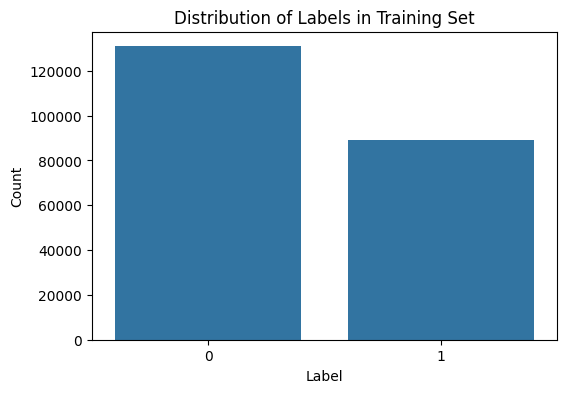

In [12]:
plt.figure(figsize=(6, 4))
sns.countplot(x='label', data=train_labels)
plt.title('Distribution of Labels in Training Set')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

In [13]:
train_labels.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


Here are examples of the images. The first set are examples of healthy cells while the second row are examples of cancer cells:

In [14]:
train_data = pd.DataFrame(train_labels)

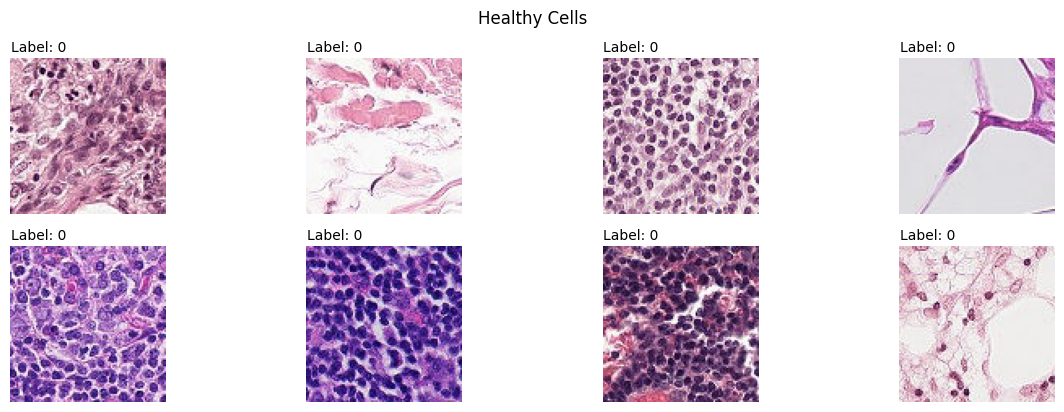

In [15]:
sample_size = min(8, len(train_data))
sample = train_data[train_data['label'] == 0].sample(n=sample_size).reset_index()

plt.figure(figsize=(12, 8))

for i, row in sample.iterrows():
    img = Image.open(f'data/train/{row.id}.tif')    
    label = row.label

    plt.subplot(4, 4, i + 1)
    plt.imshow(img)
    plt.text(0, -5, f'Label: {label}', color='k')
        
    plt.axis('off')

plt.suptitle("Healthy Cells")
plt.tight_layout()

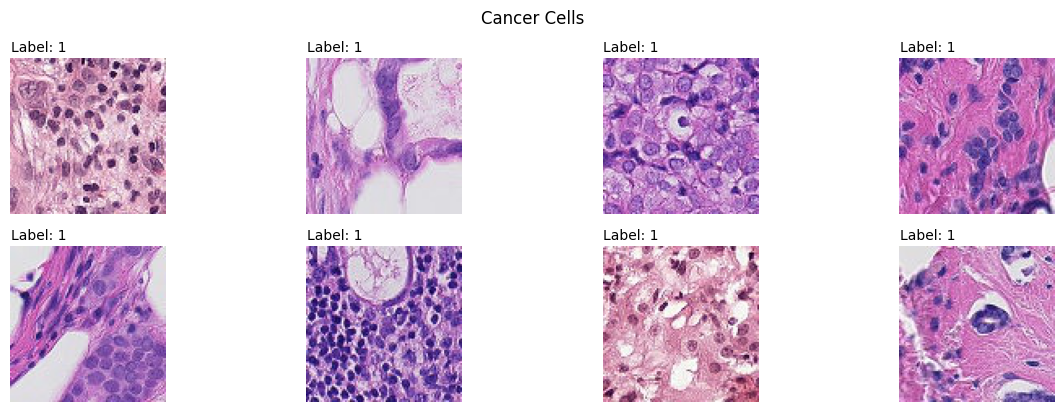

In [16]:
sample_size = min(8, len(train_data))
sample = train_data[train_data['label'] == 1].sample(n=sample_size).reset_index()

plt.figure(figsize=(12, 8))

for i, row in sample.iterrows():
    img = Image.open(f'data/train/{row.id}.tif')    
    label = row.label

    plt.subplot(4, 4, i + 1)
    plt.imshow(img)
    plt.text(0, -5, f'Label: {label}', color='k')
        
    plt.axis('off')

plt.suptitle("Cancer Cells")
plt.tight_layout()

## Image Preprocessing

In [17]:
# The label must be converted from int64 to string to work with the flow_from_dataframe function
train_labels['label'] = train_labels['label'].astype(str)

# The file id's must have the .tif extension added to work with the flow_from_dataframe function
train_labels['id'] = train_labels['id'].apply(lambda x: x + '.tif')

train_df, valid_df = train_test_split(train_labels, test_size=0.2, random_state=1, stratify=train_labels['label'])

Ensure that `id` now includes `.tif` to explore the file, and ensure that `train_labels` did not change unexpectedly.

In [18]:
train_labels.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835.tif,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif,1
2,755db6279dae599ebb4d39a9123cce439965282d.tif,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif,0
4,068aba587a4950175d04c680d38943fd488d6a9d.tif,0


In [19]:
len(train_df), len(valid_df)

(176020, 44005)

In [20]:
datagen = ImageDataGenerator(rescale=1/255)

We will be using [Keras ImageDataGenerator](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#flow_from_dataframe) for image processing. We will be using the `ImageDataGenerator` and `flow_from_dataframe` methods.

In [21]:
batch_size = 64

train_loader = datagen.flow_from_dataframe(
    dataframe = train_df,
    directory = train,
    x_col = 'id',
    y_col = 'label',
    batch_size = batch_size,
    seed = 1,
    shuffle = True,
    class_mode = 'categorical',
    target_size = (224, 224) 
)

valid_loader = datagen.flow_from_dataframe(
    dataframe = valid_df,
    directory = train,
    x_col = 'id',
    y_col = 'label',
    batch_size = batch_size,
    seed = 1,
    shuffle = True,
    class_mode = 'categorical',
    target_size = (224, 224)
)

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.


In [22]:
train_steps = len(train_loader)
valid_steps = len(valid_loader)

print(train_steps)
print(valid_steps)

2751
688


# Model Architecture

## Helper functions for Visualizations
Functions to visualize performance metrics and model visualization

In [23]:
def plot(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_' + metric])
    plt.title(str(metric).capitalize())
    plt.xlabel('Epoch')
    plt.ylabel(str(metric).capitalize())
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

## Build First Model

We will be constructing our own model using the architecture described below:

- **Convolutional layer**: 16 filters, kernel size of 3x3, and ReLU activation function.
- **MaxPooling layer**: a pool size of 2x2.
- **Second Convolutional Layer**: 32 filters, kernel size of 3x3, and ReLU activation function.
- **MaxPooling layer**: a pool size of 2x2.
- **Third Convolutional Layer**: 64 filters, kernel size of 3x3, and ReLU activation function.
- **MaxPooling layer**: a pool size of 2x2.
- **Fourth Convolutional Layer**: 80 filters, kernel size of 3x3, and ReLU activation function.
- **MaxPooling layer**: a pool size of 2x2.
- **Fifth Convolutional Layer**: 96 filters, kernel size of 3x3, and ReLU activation function.
- **MaxPooling layer**: a pool size of 2x2.
- **Flatten layer**: convert the 2D feature maps into a 1D feature vector.
- **Dense layer**: 256 units and ReLU activation function.
- **Dropout layer**: a dropout rate of 0.5 for regularization.
- **Output layer**: 2 neurons and sigmoid activation function for binary classification.

I chose to do 5 convolutional layers to capture different features of the images. The size of the filters is increased by 16 for each subsequent layers. 

The final layer has 2 neurons to predict the probability of the image belonging to either class. The sigmoid activation function ensures the output is between 0 and 1, which is suitable for binary classification.

In [31]:
batch_size = 32

In [32]:
model = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(2, 2),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(48, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(80, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', Recall(name='recall')])

model.summary()

steps_per_epoch = train_loader.samples // train_loader.batch_size
validation_steps = valid_loader.samples // valid_loader.batch_size

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)              │ (None, 222, 222, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 111, 111, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 109, 109, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 52, 52, 48)     │        13,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 26, 26, 48)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 24, 24, 64)     │        27,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 10, 10, 80)     │        46,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 5, 5, 80)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 2000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       512,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 605,602 (2.31 MB)

 Trainable params: 605,602 (2.31 MB)

 Non-trainable params: 0 (0.00 B)

In [33]:
history = model.fit(train_loader,
                    steps_per_epoch=steps_per_epoch,
                    epochs=10,
                    validation_data=valid_loader,
                    validation_steps=validation_steps,
                    callbacks=[early_stopping])

Epoch 1/10
2750/2750 ━━━━━━━━━━━━━━━━━━━━ 123s 44ms/step - accuracy: 0.7876 - loss: 0.4622 - recall: 0.7880 - val_accuracy: 0.8602 - val_loss: 0.3280 - val_recall: 0.8608
Epoch 2/10
   1/2750 ━━━━━━━━━━━━━━━━━━━━ 1:55 42ms/step - accuracy: 0.7812 - loss: 0.5671 - recall: 0.7812

2024-06-18 15:32:41.433680: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-18 15:32:41.433700: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_36]]
2024-06-18 15:32:41.433731: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 570819935335039181
2024-06-18 15:32:41.433738: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10693819818041533173
2024-06-18 15:32:41.433744: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7623724499692364517
2024-06-18 15:32:41.433748: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3080566818600510421
2024-06-18

2750/2750 ━━━━━━━━━━━━━━━━━━━━ 0s 81us/step - accuracy: 0.7812 - loss: 0.5671 - recall: 0.7812 - val_accuracy: 0.8378 - val_loss: 0.2781 - val_recall: 0.8378
Epoch 3/10
2750/2750 ━━━━━━━━━━━━━━━━━━━━ 119s 43ms/step - accuracy: 0.8684 - loss: 0.3155 - recall: 0.8686 - val_accuracy: 0.8798 - val_loss: 0.2881 - val_recall: 0.8793
Epoch 4/10
2750/2750 ━━━━━━━━━━━━━━━━━━━━ 0s 15us/step - accuracy: 0.8750 - loss: 0.3103 - recall: 0.8750 - val_accuracy: 0.8108 - val_loss: 0.3902 - val_recall: 0.8108
Epoch 5/10


2024-06-18 15:34:41.150829: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-18 15:34:41.150849: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17657815902023803206
2024-06-18 15:34:41.150872: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_36]]
2024-06-18 15:34:41.150890: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8254078329681666782
2024-06-18 15:34:41.150898: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8018569974512453530
2024-06-18 15:34:41.150907: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12563343065885132798
2024-06-

2750/2750 ━━━━━━━━━━━━━━━━━━━━ 120s 44ms/step - accuracy: 0.8953 - loss: 0.2608 - recall: 0.8953 - val_accuracy: 0.9028 - val_loss: 0.2392 - val_recall: 0.9028
Epoch 6/10
2750/2750 ━━━━━━━━━━━━━━━━━━━━ 0s 16us/step - accuracy: 0.8906 - loss: 0.2994 - recall: 0.8906 - val_accuracy: 0.9189 - val_loss: 0.1461 - val_recall: 0.9189
Epoch 7/10


2024-06-18 15:36:41.590011: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-18 15:36:41.590027: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_36]]
2024-06-18 15:36:41.590037: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 570819935335039181
2024-06-18 15:36:41.590042: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10693819818041533173
2024-06-18 15:36:41.590048: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3080566818600510421
2024-06-18 15:36:41.590052: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7623724499692364517
2024-06-18

2750/2750 ━━━━━━━━━━━━━━━━━━━━ 119s 43ms/step - accuracy: 0.9064 - loss: 0.2367 - recall: 0.9065 - val_accuracy: 0.9087 - val_loss: 0.2296 - val_recall: 0.9087
Epoch 8/10
2750/2750 ━━━━━━━━━━━━━━━━━━━━ 0s 15us/step - accuracy: 0.8594 - loss: 0.3618 - recall: 0.8438 - val_accuracy: 0.9459 - val_loss: 0.2510 - val_recall: 0.9459
Epoch 9/10


2024-06-18 15:38:40.701892: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-18 15:38:40.701911: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_36]]
2024-06-18 15:38:40.701919: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 570819935335039181
2024-06-18 15:38:40.701929: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7623724499692364517
2024-06-18 15:38:40.701937: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3080566818600510421
2024-06-18 15:38:40.701941: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 18140308623757677993
2024-06-18

2750/2750 ━━━━━━━━━━━━━━━━━━━━ 119s 43ms/step - accuracy: 0.9139 - loss: 0.2184 - recall: 0.9139 - val_accuracy: 0.8933 - val_loss: 0.2594 - val_recall: 0.8935


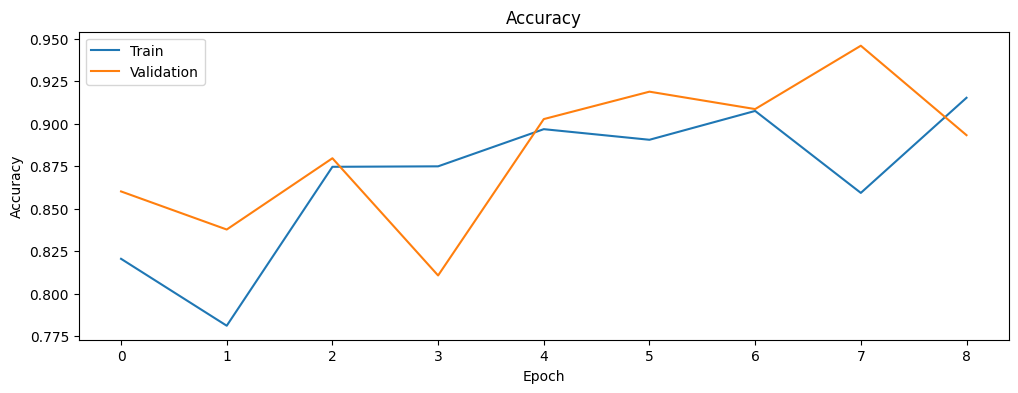

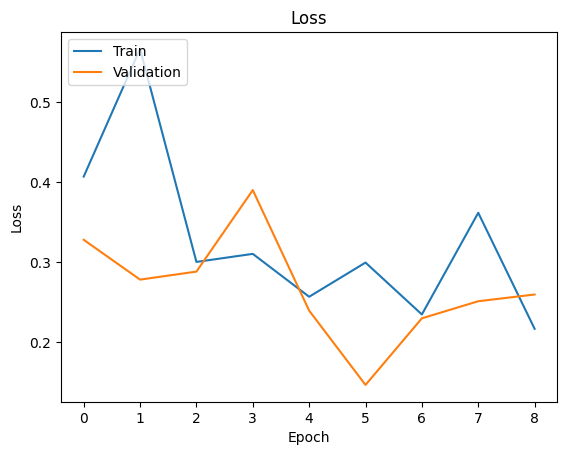

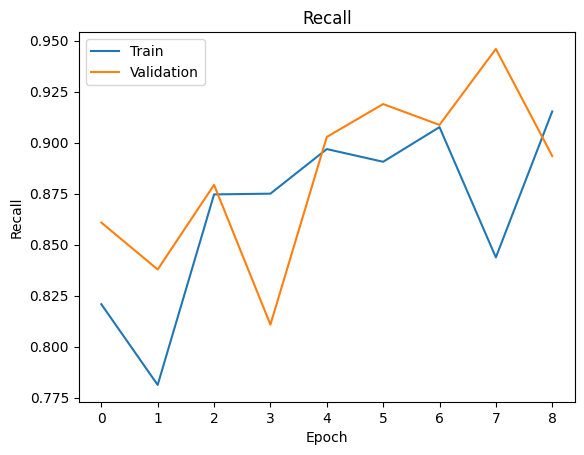

In [34]:
plt.figure(figsize=(12, 4))

plot(history, 'accuracy')
plot(history, 'loss')
plot(history, 'recall')

## Build Second Model

Taking into consideration the performance of the first model, I decided to build a second model with a slightly different architecture:
- **Convolutional layer**: 16 filters, kernel size of 3x3, ReLU activation function, and L2 regularization with a coefficient of 0.0015.
- **Convolutional layer**: 16 filters, kernel size of 3x3, ReLU activation function, and L2 regularization with a coefficient of 0.0015.
- **Batch Normalization layer**: to normalize the activations of the prev
- **MaxPooling layer**: a pool size of 2x2. Update the padding to 'same'.
- **Second Convolutional layer**: 32 filters, kernel size of 3x3, ReLU activation function, and L2 regularization with a coefficient of 0.0015.
- **Second Convolutional layer**: 32 filters, kernel size of 3x3, ReLU activation function, and L2 regularization with a coefficient of 0.0015.
- **Batch Normalization layer**: to normalize the activations of the previous layer.
- **MaxPooling layer**: a pool size of 2x2. Update the padding to 'same'.
- **Third Convolutional Layer**: 64 filters, kernel size of 3x3, ReLU activation function, and L2 regularization with a coefficient of 0.0015.
- **Third Convolutional Layer**: 64 filters, kernel size of 3x3, ReLU activation function, and L2 regularization with a coefficient of 0.0015.
- **Batch Normalization layer**: to normalize the activations of the previous layer.
- **MaxPooling layer**: a pool size of 2x2. Update the padding to 'same'.
- **Fourth Convolutional Layer**: 80 filters, kernel size of 3x3, ReLU activation function, and L2 regularization with a coefficient of 0.0015.
- **Fourth Convolutional Layer**: 80 filters, kernel size of 3x3, ReLU activation function, and L2 regularization with a coefficient of 0.0015.
- **Batch Normalization layer**: to normalize the activations of the previous layer.
- **MaxPooling layer**: a pool size of 2x2. Update the padding to 'same'.
- **Fifth Convolutional Layer**: 96 filters, kernel size of 3x3, ReLU activation function, and L2 regularization with a coefficient of 0.0015.
- **Fifth Convolutional Layer**: 96 filters, kernel size of 3x3, ReLU activation function, and L2 regularization with a coefficient of 0.0015.
- **Batch Normalization layer**: to normalize the activations of the previous layer.
- **MaxPooling layer**: a pool size of 2x2. Update the padding to 'same'.
- **Flatten layer**: convert the 2D feature maps into a 1D feature vector.
- **Dense layer**: 256 units and ReLU activation function.
- **Dropout layer**: a dropout rate of 0.5 for regularization.
- **Output layer**: 2 neurons and sigmoid activation function for binary classification.

To optimize performance, I doubled the convolutional layers for each layer to capture more complex features, I added `BatchNormalization()` between each pooling and convolutional layer in order to standardize the inputs to a layer for each mini-batch, and I used `ReduceLROnPlateau` to automatically reduce the learning rate when the validation loss plateaus.

In [35]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)

In [36]:
model2 = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(224, 224, 3), kernel_regularizer=l2(.0015)),
    Conv2D(16, (3, 3), activation='relu', kernel_regularizer=l2(.0015)),
    BatchNormalization(),
    MaxPooling2D(2, 2, padding='same'), 
    
    Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(.0015)),
    Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(.0015)),
    BatchNormalization(),
    MaxPooling2D(2, 2, padding='same'), 
    
    Conv2D(48, (3, 3), activation='relu', kernel_regularizer=l2(.0015)),
    Conv2D(48, (3, 3), activation='relu', kernel_regularizer=l2(.0015)),
    BatchNormalization(),
    MaxPooling2D(2, 2, padding='same'), 
    
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(.0015)),
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(.0015)),
    BatchNormalization(),
    MaxPooling2D(2, 2, padding='same'), 
    
    Conv2D(80, (3, 3), activation='relu', kernel_regularizer=l2(.0015)),
    Conv2D(80, (3, 3), activation='relu', kernel_regularizer=l2(.0015)),
    BatchNormalization(),
    MaxPooling2D(2, 2, padding='same'), 
    
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='sigmoid')
])

model2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', Recall(name='recall')])

model2.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_20 (Conv2D)              │ (None, 222, 222, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 220, 220, 16)   │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 220, 220, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 110, 110, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 108, 108, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 106, 106, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 106, 106, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 53, 53, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 51, 51, 48)     │        13,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 49, 49, 48)     │        20,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 49, 49, 48)     │           192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 25, 25, 48)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 23, 23, 64)     │        27,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 21, 21, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 21, 21, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 11, 11, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 9, 9, 80)       │        46,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 7, 7, 80)       │        57,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 7, 7, 80)       │           320 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 4, 4, 80)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 549,202 (2.10 MB)

 Trainable params: 548,722 (2.09 MB)

 Non-trainable params: 480 (1.88 KB)

In [37]:
history = model2.fit(train_loader,
                    steps_per_epoch=steps_per_epoch,
                    epochs=10,
                    validation_data=valid_loader,
                    validation_steps=validation_steps,
                    callbacks=[early_stopping, reduce_lr])

Epoch 1/10
2750/2750 ━━━━━━━━━━━━━━━━━━━━ 365s 131ms/step - accuracy: 0.8188 - loss: 0.8418 - recall: 0.8150 - val_accuracy: 0.7818 - val_loss: 0.6365 - val_recall: 0.7818 - learning_rate: 0.0010
Epoch 2/10
   1/2750 ━━━━━━━━━━━━━━━━━━━━ 5:05 111ms/step - accuracy: 0.8281 - loss: 0.4667 - recall: 0.8281

2024-06-18 16:07:48.467196: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-18 16:07:48.467212: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/gradient_tape/compile_loss/binary_crossentropy/logistic_loss/mul/Shape_1/_190]]
2024-06-18 16:07:48.467220: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5014764819798885512
2024-06-18 16:07:48.467228: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 18031163371508204261
2024-06-18 16:07:48.467232: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1459953616400188772
2024-06-18 16:07:48.467234: I tensorflow/core/framework/local_rendezvous.cc:

2750/2750 ━━━━━━━━━━━━━━━━━━━━ 0s 101us/step - accuracy: 0.8281 - loss: 0.4667 - recall: 0.8281 - val_accuracy: 0.7838 - val_loss: 0.5006 - val_recall: 0.7838 - learning_rate: 0.0010
Epoch 3/10


2024-06-18 16:07:48.707458: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-18 16:07:48.707474: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[Shape/_6]]
2024-06-18 16:07:48.707485: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17714260483462166931
2024-06-18 16:07:48.707489: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15361265361067928171
2024-06-18 16:07:48.707493: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6566093088366530557
2024-06-18 16:07:48.707497: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14030740243704369398
2024-06-18 16:07:4

2750/2750 ━━━━━━━━━━━━━━━━━━━━ 351s 127ms/step - accuracy: 0.8756 - loss: 0.3765 - recall: 0.8755 - val_accuracy: 0.6471 - val_loss: 0.7300 - val_recall: 0.6471 - learning_rate: 0.0010


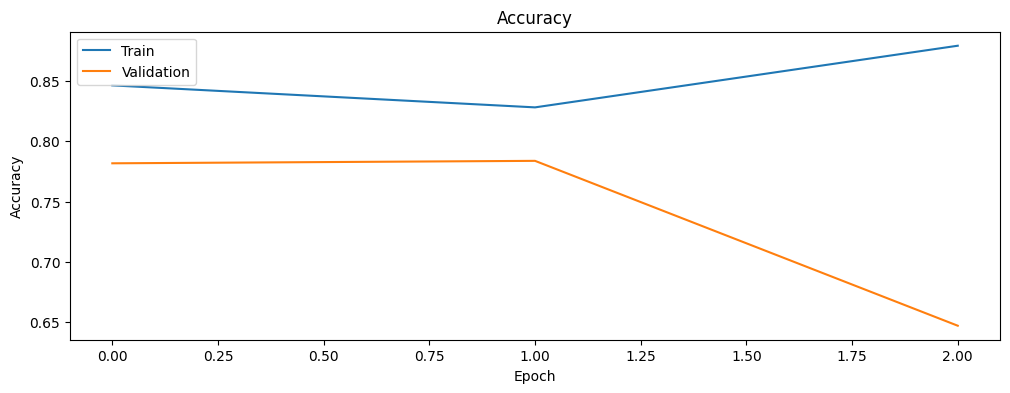

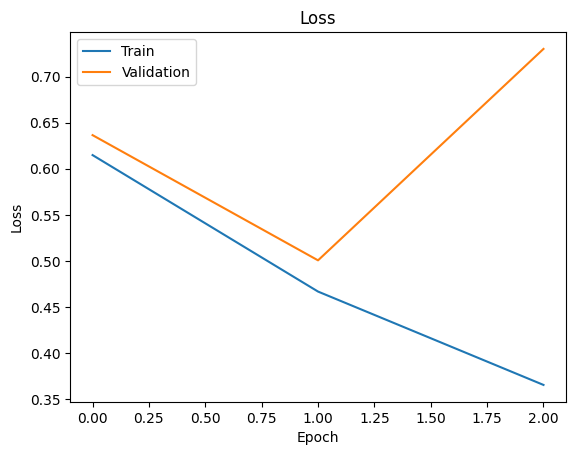

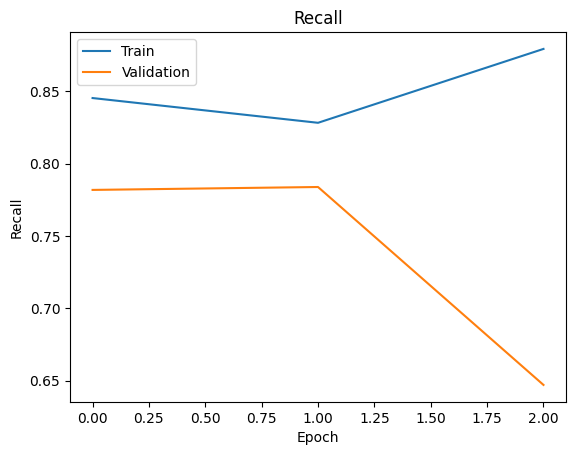

In [38]:
plt.figure(figsize=(12, 4))

plot(history, 'accuracy')
plot(history, 'loss')
plot(history, 'recall')

## Build Third Model

Doubling the layers did not seem to add any performance. In fact, it seems that it was more inefficient than the first model. 

To fix that, I have imposed a combination of the previous two architectures:
- **Convolutional layer**: 16 filters, kernel size of 3x3, and ReLU activation function.
- **Batch Normalization layer**: to normalize the activations of the prev
- **MaxPooling layer**: a pool size of 2x2.
- **Second Convolutional Layer**: 32 filters, kernel size of 3x3, and ReLU activation function.
- **Batch Normalization layer**: to normalize the activations of the prev
- **MaxPooling layer**: a pool size of 2x2.
- **Third Convolutional Layer**: 64 filters, kernel size of 3x3, and ReLU activation function.
- **Batch Normalization layer**: to normalize the activations of the prev
- **MaxPooling layer**: a pool size of 2x2.
- **Fourth Convolutional Layer**: 80 filters, kernel size of 3x3, and ReLU activation function.
- **Batch Normalization layer**: to normalize the activations of the prev
- **MaxPooling layer**: a pool size of 2x2.
- **Fifth Convolutional Layer**: 96 filters, kernel size of 3x3, and ReLU activation function.
- **Batch Normalization layer**: to normalize the activations of the prev
- **MaxPooling layer**: a pool size of 2x2.
- **Flatten layer**: convert the 2D feature maps into a 1D feature vector.
- **Dense layer**: 256 units and ReLU activation function.
- **Dropout layer**: a dropout rate of 0.5 for regularization.
- **Output layer**: 2 neurons and sigmoid activation function for binary classification.

In [39]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)

In [40]:
model3 = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(224, 224, 3), kernel_regularizer=l2(.0015)),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(.0015)),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Conv2D(48, (3, 3), activation='relu', kernel_regularizer=l2(.0015)),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(.0015)),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Conv2D(80, (3, 3), activation='relu', kernel_regularizer=l2(.0015)),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='sigmoid')
])

model3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', Recall(name='recall')])

model3.summary()

steps_per_epoch = train_loader.samples // train_loader.batch_size
validation_steps = valid_loader.samples // valid_loader.batch_size

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_30 (Conv2D)              │ (None, 222, 222, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 222, 222, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 111, 111, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 109, 109, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 109, 109, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 52, 52, 48)     │        13,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 52, 52, 48)     │           192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 26, 26, 48)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 24, 24, 64)     │        27,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 10, 10, 80)     │        46,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 10, 10, 80)     │           320 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 5, 5, 80)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 2000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │       512,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 606,562 (2.31 MB)

 Trainable params: 606,082 (2.31 MB)

 Non-trainable params: 480 (1.88 KB)

In [41]:
history = model3.fit(train_loader,
                    steps_per_epoch=steps_per_epoch,
                    epochs=10,
                    validation_data=valid_loader,
                    validation_steps=validation_steps,
                    callbacks=[early_stopping, reduce_lr])

Epoch 1/10
2750/2750 ━━━━━━━━━━━━━━━━━━━━ 1032s 374ms/step - accuracy: 0.8274 - loss: 0.6034 - recall: 0.8260 - val_accuracy: 0.8677 - val_loss: 0.4148 - val_recall: 0.8684 - learning_rate: 0.0010
Epoch 2/10
   1/2750 ━━━━━━━━━━━━━━━━━━━━ 4:42 103ms/step - accuracy: 0.8281 - loss: 0.5672 - recall: 0.8281

2024-06-18 16:30:51.487616: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-18 16:30:51.487632: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11799595529300820084
2024-06-18 16:30:51.487637: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11050487239782465594
2024-06-18 16:30:51.487643: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3366987934202430312
2024-06-18 16:30:51.487646: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_56]]
2024-06-18 16:30:51.487657: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1717365689055297805
2024-06-

2750/2750 ━━━━━━━━━━━━━━━━━━━━ 0s 85us/step - accuracy: 0.8281 - loss: 0.5672 - recall: 0.8281 - val_accuracy: 0.8378 - val_loss: 0.4971 - val_recall: 0.8378 - learning_rate: 0.0010
Epoch 3/10
2750/2750 ━━━━━━━━━━━━━━━━━━━━ 215s 78ms/step - accuracy: 0.8898 - loss: 0.3478 - recall: 0.8897 - val_accuracy: 0.8997 - val_loss: 0.3216 - val_recall: 0.8995 - learning_rate: 0.0010
Epoch 4/10
2750/2750 ━━━━━━━━━━━━━━━━━━━━ 0s 17us/step - accuracy: 0.8750 - loss: 0.3337 - recall: 0.8750 - val_accuracy: 0.8378 - val_loss: 0.3453 - val_recall: 0.8378 - learning_rate: 0.0010
Epoch 5/10


2024-06-18 16:34:26.888244: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-18 16:34:26.888264: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11799595529300820084
2024-06-18 16:34:26.888270: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11050487239782465594
2024-06-18 16:34:26.888278: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17087033480998618302
2024-06-18 16:34:26.888280: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/sequential_4_1/dropout_4_1/add/_114]]
2024-06-18 16:34:26.888299: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelle

2750/2750 ━━━━━━━━━━━━━━━━━━━━ 213s 77ms/step - accuracy: 0.9037 - loss: 0.3145 - recall: 0.9035 - val_accuracy: 0.8465 - val_loss: 0.4352 - val_recall: 0.8469 - learning_rate: 0.0010
Epoch 6/10
2750/2750 ━━━━━━━━━━━━━━━━━━━━ 0s 16us/step - accuracy: 0.8906 - loss: 0.2742 - recall: 0.8906 - val_accuracy: 0.8649 - val_loss: 0.4179 - val_recall: 0.8649 - learning_rate: 0.0010


2024-06-18 16:38:00.337681: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-18 16:38:00.337698: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/add_12/_82]]
2024-06-18 16:38:00.337718: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10822266692719005828
2024-06-18 16:38:00.337736: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11799595529300820084
2024-06-18 16:38:00.337746: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11913236569758396456
2024-06-18 16:38:00.337750: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3580165

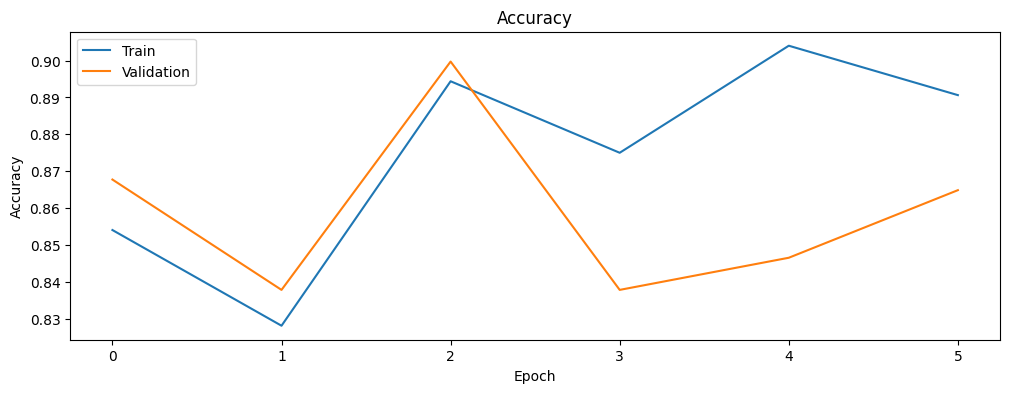

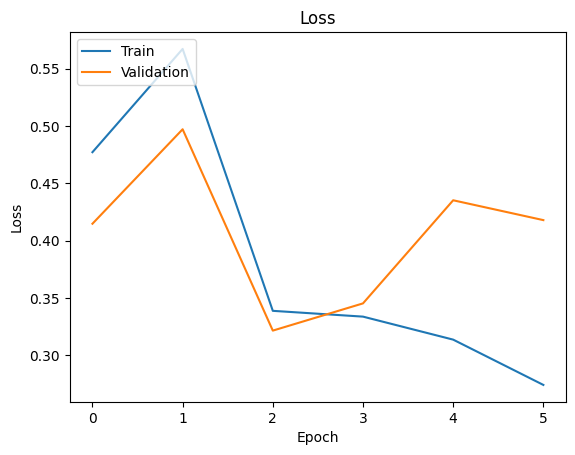

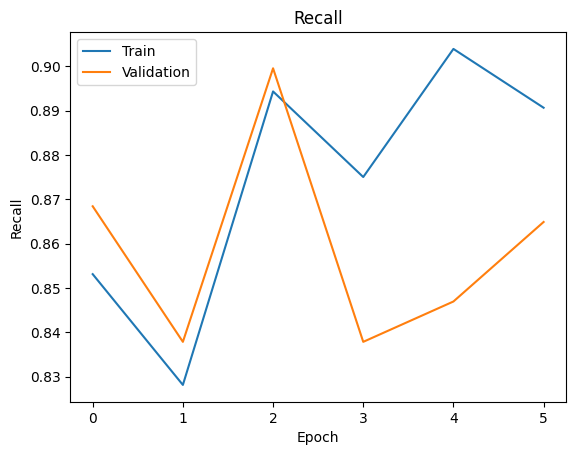

In [42]:
plt.figure(figsize=(12, 4))

plot(history, 'accuracy')
plot(history, 'loss')
plot(history, 'recall')

# Results & Analysis

The best model architecture for the given dataset is **Model 1**. It achieved an accuracy of 91.39% and 89.33%, loss of 21.84% and 25.94%, and recall of 91.39% and 89.35% on the training and validation data respectively. 

Model 2 was the worst performing architecture. I think that if I increased the amount of steps or the amount of data, this model would have performed well. 

Model 3 was similar to model 2 and only made it half way through. The model is quite unreliable with its training accuracy swings from ~83% to ~90%, while validation is further off.

The tables below summarize the performance of each model on the training data:

**Model 1**:
|  Metric  | Training |  Valid   |
| -------- | -------- | -------- |
| Accuracy | 0.9139	  | 0.8933   |
| Loss     | 0.2184	  | 0.2594   |
| Recall   | 0.9139	  | 0.8935   |

**Model 2**:
|  Metric  | Training |  Valid   |
| -------- | -------- | -------- |
| Accuracy | 0.8756   | 0.6471   |
| Loss     | 0.3765   | 0.7300   |
| Recall   | 0.8755   | 0.6471   |

**Model 3**:
|  Metric  | Training |  Valid   |
| -------- | -------- | -------- |
| Accuracy | 0.8906   | 0.8649   |
| Loss     | 0.2742   | 0.4179   |
| Recall   | 0.8906   | 0.8649   |

# Test Model

As stated earlier, the best model architecture for the given dataset is Model 1. We are going to use this model to test the performance on the test dataset.

## Construction

In [43]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_files = os.listdir(test)
test_dataframe = pd.DataFrame(test_files, columns=['id'])
test_loader = test_datagen.flow_from_dataframe(
    dataframe = test_dataframe,
    directory = test,
    x_col='id',
    y_col=None,
    target_size=(224, 224),
    class_mode=None,
    workers=4,
    use_multiprocessing=True)

Found 57458 validated image filenames.


## Predict

In [44]:
predictions = model.predict(test_loader)
predictions = np.transpose(predictions)[0]
print(f"Number of predictions: {len(predictions)}")
print(f"Number of test samples: {len(test_dataframe)}")

binary_predictions = (predictions >= 0.5).astype(int).flatten()
print(len(binary_predictions))

submission_dataframe = pd.DataFrame()
submission_dataframe['id'] = test_dataframe['id'].apply(lambda x: x.split('.')[0])
submission_dataframe['label'] = binary_predictions
submission_dataframe.to_csv('submission.csv', index=False)

   1/1796 ━━━━━━━━━━━━━━━━━━━━ 5:29 184ms/step

/Users/devinlynch/Desktop/Grad School/Summer 1 2024/CSCA 5642/programming_assignments/week3/CNN-Cancer-Detection/.venv/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1796/1796 ━━━━━━━━━━━━━━━━━━━━ 27s 15ms/step
Number of predictions: 57458
Number of test samples: 57458
57458


# Conclusion

The model did not perform as well as I was expecting. It received a 50.21% on the test data when I was expecting to be around 85-90% accurate. 

I believe this would be because of over fitting. I think that my model learned the training data too well and that different methods of regularization may have helped increase the accuracy.